In [1]:
# imports
import keras
import numpy as np
import pandas as pd
import torch_cnn as tcnn
from keras_cnn import keras_CNN as kcnn
import data_processing as d
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split   

In [2]:
# Data retieval
X, y = d.get_encoded_data()

# Keras CNN Data
X_train, X_test, y_train, y_test = d.splitData(X, y)

# Convert data to Tensors to Incease Computation time for Torch CNN
X_tensor_train,Y_tensor_train  = d.toTensors(X, y)

# Change Y data for SVM
svm_X_train, svm_X_test, svm_y_train, svm_y_test =  train_test_split(X, d.get_SVM_y(), test_size=0.33, random_state=1)

In [3]:
# Variables
EPOCHS = 10 # arbitrary

# Keras CNN
KERNEL_SIZE = 3
FILTERS = 128
DROPOUT_RATE = 0.25

# Torch CNN
N_FEATURES = X_train.shape[1] # Number of features for the input layer
NUM_ROWS_TRAINING = X_train.shape[0] # Number of rows
N_HIDDEN = N_FEATURES * 10 # Size of first linear layer
N_CNN_KERNEL, MAX_POOL_KERNEL = 3, 4 # CNN kernel size

test acc: 0.9591948416569511
test acc: 0.8835327987817935
test acc: 0.9425158818910752
test acc: 0.9425158818910752
test acc: 0.8537200504413619
test acc: 0.9665707011825169
test acc: 0.9712579409455376
test acc: 0.9425158818910752
test acc: 0.9687596659449428
test acc: 0.9425158818910752


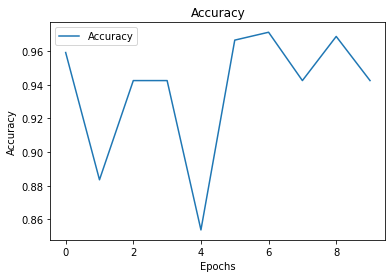

In [4]:
# Keras CNN
accuracy=[]
#Build Model
for x in range(0,EPOCHS):
    cnn1D = kcnn(7, 500)
    new_X_train, new_X_test, new_y_train, new_y_test = cnn1D.reshape_and_chng_type(X_train, X_test, y_train, y_test)
    model = cnn1D.getModel()
    optimizer = keras.optimizers.Nadam(learning_rate=1e-3, decay=5e-4)

    model.compile(optimizer, 'mse', metrics=[keras.metrics.Accuracy()])

    history = model.fit(
        new_X_train,
        new_y_train,
        batch_size=256,
        verbose=0,
        epochs=150
    )

    # for metric in history.history:
    #     cnn1D.plot(history.history, EPOCHS, metric)
    #print("Evaluate on test data")
    results = model.predict(new_X_test, batch_size=256)
    results = results.reshape(results.shape[1], results.shape[2]).astype(int)

    count, failures, successes = 0, 0, 0

    for i in range(len(results)):
        for j in range(len(results[i])):
            count += 1
            if results[i][j] == int(y_test[i][j]):
                successes += 1
    accuracy.append(successes/count)
    print("test acc:", float(successes) / count)
res = {'Accuracy':accuracy}
d.plot(res, 10, "Accuracy")

step 1 acc = 0.9556367063258334, loss = 7.911906643556416, roc_auc = 0.5606456137342893 

step 2 acc = 0.9173283072211097, loss = 18.067029849213565, roc_auc = 0.5270517714958368 

step 3 acc = 0.9675344563552833, loss = 7.240977239925195, roc_auc = 0.554014077952148 

step 4 acc = 0.9727569010876821, loss = 6.080563441389005, roc_auc = 0.5583641061203388 

step 5 acc = 0.9751128911925236, loss = 5.582129910650638, roc_auc = 0.5588098197987682 

step 6 acc = 0.9770212431774453, loss = 5.148624034801754, roc_auc = 0.574020717154402 

step 7 acc = 0.9766442847606707, loss = 5.216181953443806, roc_auc = 0.5747821723882579 

step 8 acc = 0.9775788275022578, loss = 4.987540828506213, roc_auc = 0.5768482475849643 

step 9 acc = 0.9791573408725016, loss = 4.634888352710048, roc_auc = 0.5802680039328563 

step 10 acc = 0.9804531354301645, loss = 4.366169453689552, roc_auc = 0.5862468905641963 



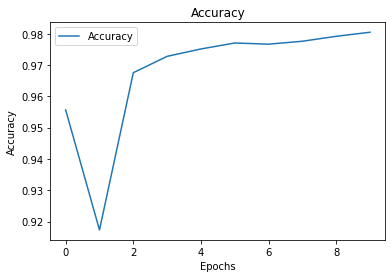

In [5]:
### Torch CNN
# Build CNN
net = tcnn.CNN(n_feature=N_FEATURES, n_hidden=N_HIDDEN, n_output=13, n_cnn_kernel=N_CNN_KERNEL)   # define the network    
# Train and Test
train_results, results = tcnn.trainTestCNN(net,X_tensor_train,Y_tensor_train, EPOCHS)
# Plotting
d.plot(results, 10, "Accuracy")

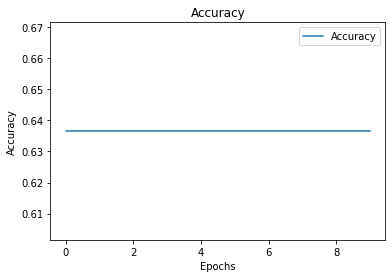

In [6]:
# SVM
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
accuracy = []
# Train and Test
for x in range(0,EPOCHS):
    clf.fit(svm_X_train,  svm_y_train)
    predictions=clf.predict(svm_X_test)
    accuracy.append(accuracy_score(svm_y_test, predictions))
# Plotting        
results = {'Accuracy':accuracy}
d.plot(results, 10, 'Accuracy')       